# Groups of features

Shapash allows the use of groups of features.  
With groups of features you can regroup variables together and use the different functions of Shapash to analyze these groups.

For example if your model uses a lot of features you may want to regroup features that share a common theme.  
This way **you can visualize and compare the importance of these themes and how they are used by your model.** 

Contents of this tutorial:
- Build a model
- Contruct groups of features
- Compile Shapash SmartExplainer with the groups
- Start Shapash WebApp
- Explore the functions of Shapash using groups
- Use groups of features in production with SmartPredictor object

Data from Kaggle [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

## Motivation

In this use case, we have a lot of features that describe the house very precisely.  

However, when analyzing our model, **you may want to get more general insights of the themes that are most important in setting the price of a property**.  
This way, rather than having to check the 6 features describing a garage, you can have a more general idea of how important the garage is by grouping these 6 features together. Shapash allows you to visualize the role of each group
in the features importance plot.  

Also, you may want to understand why your model predicted such an important price for a specific house. If many features describing the location of the house are contributing slightly more than usual to a higher price, **it may not be visible directly that the price is due to the location because of the number of features**. But grouping these variables together allows to easily understand a specific prediction. Shapash also allows you to group features together in local plots.

In [2]:
import pandas as pd
from category_encoders import OrdinalEncoder
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

## Building a supervized model 

### Load House Prices data

In [3]:
from shapash.data.data_loader import data_loading
house_df, house_dict = data_loading('house_prices')

In [4]:
house_df.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,2-Story 1946 & Newer,Residential Low Density,8450,Paved,Regular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Inside lot,Gentle slope,College Creek,...,0,0,0,0,0,2,2008,Warranty Deed - Conventional,Normal Sale,208500
2,1-Story 1946 & Newer All Styles,Residential Low Density,9600,Paved,Regular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Frontage on 2 sides of property,Gentle slope,Veenker,...,0,0,0,0,0,5,2007,Warranty Deed - Conventional,Normal Sale,181500
3,2-Story 1946 & Newer,Residential Low Density,11250,Paved,Slightly irregular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Inside lot,Gentle slope,College Creek,...,0,0,0,0,0,9,2008,Warranty Deed - Conventional,Normal Sale,223500
4,2-Story 1945 & Older,Residential Low Density,9550,Paved,Slightly irregular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Corner lot,Gentle slope,Crawford,...,272,0,0,0,0,2,2006,Warranty Deed - Conventional,Abnormal Sale,140000
5,2-Story 1946 & Newer,Residential Low Density,14260,Paved,Slightly irregular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Frontage on 2 sides of property,Gentle slope,Northridge,...,0,0,0,0,0,12,2008,Warranty Deed - Conventional,Normal Sale,250000


In [5]:
y = house_df['SalePrice']
X = house_df.drop('SalePrice', axis=1)

### Encoding Categorical Features 

In [6]:
categorical_features = [col for col in X.columns if X[col].dtype == 'object']

encoder = OrdinalEncoder(
    cols=categorical_features,
    handle_unknown='ignore',
    return_df=True
).fit(X)

X = encoder.transform(X)

### Train / Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=1)

### Model fitting

In [8]:
regressor = LGBMRegressor(n_estimators=200).fit(X_train, y_train)

## Construct groups of features

There are quite a lot of features used by the model and it can be hard to compare them.

**We can regroup the features that share similarities in order to identify which topic is important.**

In our example we constructed the following new groups :
- `location`: features related to the location of the house
- `size`: features that measure part of the house
- `aspect`: features that evaluate the style of any part of the house 
- `condition`: features related to the quality of anything in the house 
- `configuration`: features about the general configuration / shape of the house
- `equipment`: features that describe the equipment of the house (electricity, gas, heating...)
- `garage`: features related to the garage (style, ...) 
- `sale`: features related to the sale of the house

In [9]:
# We construct the groups as a dictionary of string keys and list of string values
# All the features inside the list will belong to the same group
features_groups = {
    "location": ["MSZoning", "Neighborhood", "Condition1", "Condition2"],
    "size": [
        "LotArea",
        "MasVnrArea",
        "BsmtQual",
        "BsmtFinSF2",
        "BsmtUnfSF",
        "TotalBsmtSF",
        "1stFlrSF",
        "2ndFlrSF",
        "GrLivArea",
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "3SsnPorch",
        "ScreenPorch",
        "PoolArea",
        "BsmtFinSF1"
    ],
    "aspect": [
        "LotShape",
        "LandContour",
        "RoofStyle",
        "RoofMatl",
        "Exterior1st",
        "MasVnrType",
    ],
    "condition": [
        "OverallQual",
        "OverallCond",
        "ExterQual",
        "ExterCond",
        "BsmtCond",
        "BsmtFinType1",
        "BsmtFinType2",
        "HeatingQC",
        "KitchenQual"
    ],
    "configuration": ["LotConfig", "LandSlope", "BldgType", "HouseStyle"],
    "equipment": ["Heating", "CentralAir", "Electrical"],
    "garage": [
        "GarageType",
        "GarageYrBlt",
        "GarageFinish",
        "GarageArea",
        "GarageQual",
        "GarageCond",
    ],
    "sale": ["SaleType", "SaleCondition", "MoSold", "YrSold"]
}

**Optional : we can also give labels to groups names**

In [10]:
groups_labels = {
    'location': 'Location of the property',
    'size' : 'Size of different elements in the house',
    'aspect': 'Aspect of the house',
    'condition': 'Quality of the materials and parts of the property',
    'configuration': 'Configuration of the house',
    'equipment': 'All equipments',
    'garage': 'Garage group of features',
    'sale': 'Sale information'
}
house_dict.update(groups_labels)

## Compile Shapash SmartExplainer object using groups

In [11]:
from shapash.explainer.smart_explainer import SmartExplainer
# optional parameter, specifies label for features and groups name
xpl = SmartExplainer(features_dict=house_dict)  

In [12]:
xpl.compile(
    x=X_test,
    model=regressor,
    preprocessing=encoder,
    features_groups=features_groups
)

Backend: Shap TreeExplainer


## Start WebApp

We can now start the webapp using the following cell.

The groups of features are visible by default on the features importance plot.  
You can disable the groups using the `groups` switch button.

Also you can click on a group's bar to display the features importance of the features inside the group.

In [ ]:
app = xpl.run_app(title_story='House Prices')

**Stop the WebApp after using it**

In [ ]:
app.kill()

## Explore the functions of Shapash using groups

### Features importance plot

**Display the features importance plot that includes the groups and excludes the features inside each group**

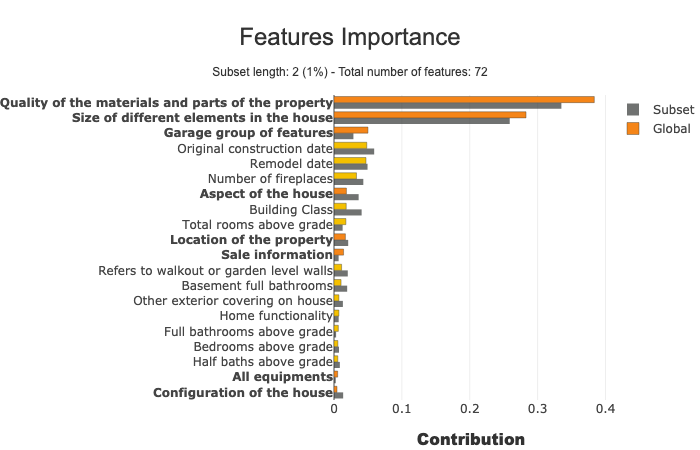

In [13]:
xpl.plot.features_importance(selection=[259, 268])

**Display the features importance plot of the features inside one group**

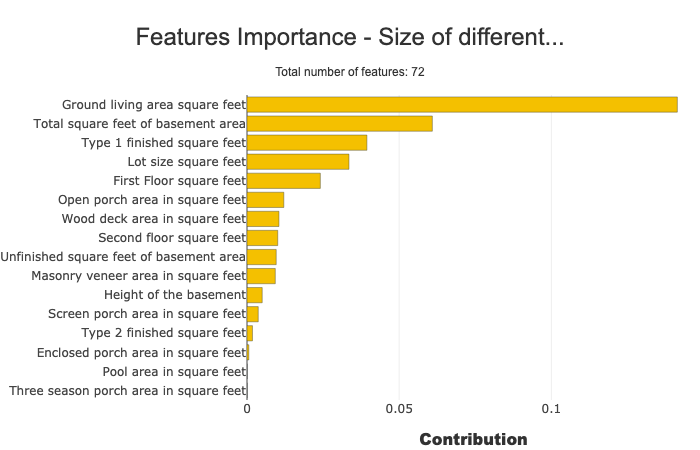

In [14]:
xpl.plot.features_importance(group_name='size')

### Contribution plot

**Plot the shap values of each observation of a group of features**  
The features values were projected on the x axis using t-SNE.  
The values of the features (top 4 features only) can be visualized using the hover text.

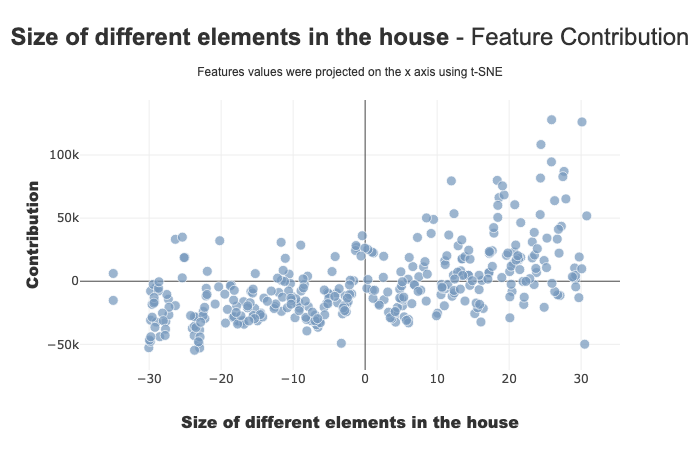

In [15]:
xpl.plot.contribution_plot('size')

### Local plot

By default, Shapash will display the groups in the local plot.

You can directly see the impact of the different groups of features for the given observation. 

In [16]:
xpl.filter(max_contrib=8)

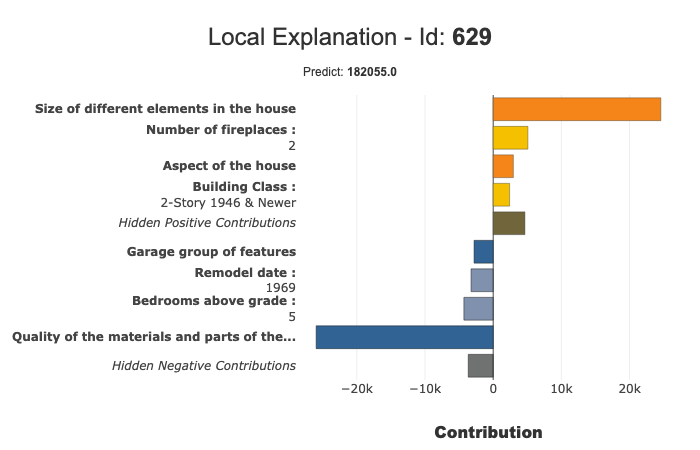

In [17]:
xpl.plot.local_plot(index=629)

You can also display the features without the groups using the following parameters :

In [18]:
xpl.filter(max_contrib=6, display_groups=False)

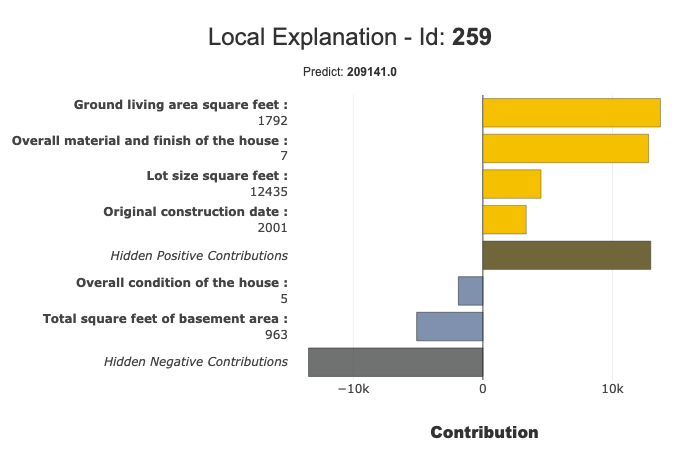

In [19]:
xpl.plot.local_plot(index=259, display_groups=False)

# Use groups of features in production with SmartPredictor object

In [20]:
predictor = xpl.to_smartpredictor()

**Create an imput and use add_input method of SmartPredictor object**

In [21]:
sample_input = house_df.sample(4).drop('SalePrice', axis=1)
sample_input

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1255,2-Story 1946 & Newer,Residential Low Density,6931,Paved,Regular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Inside lot,Gentle slope,Edwards,...,128,0,0,0,0,0,7,2008,Warranty Deed - Conventional,Normal Sale
539,1-Story 1946 & Newer All Styles,Residential Low Density,11553,Paved,Slightly irregular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Inside lot,Gentle slope,Sawyer,...,0,0,0,0,0,0,7,2006,Warranty Deed - Conventional,Normal Sale
1234,1-Story 1946 & Newer All Styles,Residential Low Density,12160,Paved,Slightly irregular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Inside lot,Gentle slope,North Ames,...,0,0,0,0,0,0,5,2010,Court Officer Deed/Estate,Abnormal Sale
932,1-Story 1946 & Newer All Styles,Residential Low Density,9100,Paved,Regular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Inside lot,Gentle slope,North Ames,...,0,0,0,0,0,0,7,2009,Warranty Deed - Conventional,Normal Sale


In [22]:
predictor.add_input(sample_input)

**Get detailed explanability associated to the predictions on this input**  
The contributions will contain the groups we created by default but you can replace the groups by their corresponding features using the `use_groups` parameter

In [23]:
predictor.detail_contributions()

,ypred,MSSubClass,Street,Utilities,YearBuilt,YearRemodAdd,Exterior2nd,Foundation,BsmtExposure,LowQualFinSF,...,PavedDrive,MiscVal,location,size,aspect,condition,configuration,equipment,garage,sale
Id,,,,,,,,,,,,,,,,,,,,,
1255,167101.689945,2022.955410,0.0,0.0,3566.611746,2318.762811,-135.758226,670.252776,-316.263453,0.0,...,81.470544,-21.196985,-1253.182071,-22856.437496,448.557415,4997.661237,-325.887026,-8.270804,-4692.738022,-587.247917
539,146602.085606,617.163673,0.0,0.0,49.249960,-2831.238572,-567.324797,-111.549994,-1161.145511,0.0,...,99.093103,-15.616154,-125.650935,-6668.038332,2137.907647,-26117.318028,-345.655208,194.633660,-3447.522861,548.328347
1234,135305.243500,854.499546,0.0,0.0,-527.348489,-3603.398024,-295.536633,-72.828222,-1095.802559,0.0,...,86.062890,-18.134173,-113.066784,-8137.990451,1856.698753,-29027.567085,-140.738757,266.265693,1751.091220,-6354.777786
932,124610.588354,629.471711,0.0,0.0,-318.165513,-2989.957644,117.773632,-180.831146,-272.731269,0.0,...,82.546860,-23.235464,360.367470,-24239.319891,148.975617,-26253.720543,-189.878239,330.587338,-1831.019154,-478.090613


In [24]:
# Replace groups of features we created with their corresponding features contributions
predictor.detail_contributions(use_groups=False)

,ypred,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1255,167101.689945,2022.955410,390.583668,-3675.778965,0.0,-344.458321,-69.540243,0.0,-214.070511,0.0,...,953.546838,27.440793,0.0,-308.508019,0.0,-21.196985,-115.891353,-353.801095,-155.136329,37.580860
539,146602.085606,617.163673,336.067419,1488.359293,0.0,1011.641443,50.155481,0.0,-288.709503,0.0,...,-280.064602,-25.195808,0.0,-176.311544,0.0,-15.616154,10.434529,185.608696,-150.916514,503.201637
1234,135305.243500,854.499546,310.201207,-1036.930907,0.0,688.747249,41.385081,0.0,-160.869509,0.0,...,-430.910521,-49.813019,0.0,-202.246385,0.0,-18.134173,466.024410,-1686.843091,-62.138536,-5071.820570
932,124610.588354,629.471711,276.755513,95.630997,0.0,-502.330389,112.967798,0.0,-149.733670,0.0,...,-940.311338,-42.016907,0.0,-261.471536,0.0,-23.235464,-441.400763,-375.429566,-110.807895,449.547611


**Compute a summary of these contributions**  
Configure the summary using the `modify_mask` method :

In [25]:
predictor.modify_mask(max_contrib=4)

The `summarize` method will contain the groups of features contributions and the `value_x` columns will contain all the values of the features of the corresponding group as a dict.

In [26]:
predictor.summarize()

,ypred,feature_1,value_1,contribution_1,feature_2,value_2,contribution_2,feature_3,value_3,contribution_3,feature_4,value_4,contribution_4
1255,167101.689945,Size of different elements in the house,"{'LotArea': 6931.0, 'MasVnrArea': 92.0, 'BsmtQ...",-22856.437496,Quality of the materials and parts of the prop...,"{'OverallQual': 7, 'OverallCond': 5, 'ExterQua...",4997.661237,Garage group of features,"{'GarageType': 3.0, 'GarageYrBlt': 2003.0, 'Ga...",-4692.738022,Original construction date,2003,3566.611746
539,146602.085606,Quality of the materials and parts of the prop...,"{'OverallQual': 5, 'OverallCond': 5, 'ExterQua...",-26117.318028,Size of different elements in the house,"{'LotArea': 11553.0, 'MasVnrArea': 188.0, 'Bsm...",-6668.038332,Garage group of features,"{'GarageType': 1.0, 'GarageYrBlt': 1968.0, 'Ga...",-3447.522861,Remodel date,1968,-2831.238572
1234,135305.243500,Quality of the materials and parts of the prop...,"{'OverallQual': 5, 'OverallCond': 5, 'ExterQua...",-29027.567085,Size of different elements in the house,"{'LotArea': 12160.0, 'MasVnrArea': 180.0, 'Bsm...",-8137.990451,Sale information,"{'SaleType': 3, 'SaleCondition': 2, 'MoSold': ...",-6354.777786,Remodel date,1959,-3603.398024
932,124610.588354,Quality of the materials and parts of the prop...,"{'OverallQual': 5, 'OverallCond': 6, 'ExterQua...",-26253.720543,Size of different elements in the house,"{'LotArea': 9100.0, 'MasVnrArea': 0.0, 'BsmtQu...",-24239.319891,Remodel date,1965,-2989.957644,Number of fireplaces,0,-1854.21146


In [27]:
# Removes the groups of features in the summary and replace them with their corresponding features
predictor.summarize(use_groups=False)

,ypred,feature_1,value_1,contribution_1,feature_2,value_2,contribution_2,feature_3,value_3,contribution_3,feature_4,value_4,contribution_4
1255,167101.689945,Total square feet of basement area,746,-8038.03965,Overall material and finish of the house,7,7699.498364,Type 1 finished square feet,0,-5336.161017,Size of garage in square feet,397,-3850.892263
539,146602.085606,Overall material and finish of the house,5,-22467.580322,Ground living area square feet,1159,-13273.071117,Wood deck area in square feet,466,3975.866031,Size of garage in square feet,336,-2883.838711
1234,135305.243500,Overall material and finish of the house,5,-25444.850571,Ground living area square feet,1188,-11480.122222,Condition of sale,Abnormal Sale,-5071.82057,Total square feet of basement area,1188,3914.461608
932,124610.588354,Overall material and finish of the house,5,-24922.127006,Ground living area square feet,925,-14783.518353,Total square feet of basement area,925,-5322.686613,Remodel date,1965,-2989.957644
